# Using sklearn 'train test split'

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
from build import create_model
import os
import keras_tuner
import cv2

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-10 02:40:31.809766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 02:40:31.809899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
epochs = 40
batch_size = 32
learning_rate = 1e-2
target_size = (64,64)

In [3]:
dataset_path = 'UTKFace'

# labels list

gender_labels = [] #2
image_data = [] #4

# loop over the input images
for imagePath in os.listdir(dataset_path):
    # extract
    label = imagePath.split('_')[1]
    label = 0 if label == '0' else 1
    gender_labels.append(label)
    # load the image, pre-process it, and store it in the data list
    image = load_img(os.path.join(dataset_path, imagePath), target_size=target_size)
    # image to array
    image = img_to_array(image)
    image_data.append(image)

In [4]:
image_data = np.array(image_data, dtype="float") / 255.0
gender_labels = np.array(gender_labels)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(image_data, gender_labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)
print(len(trainX), len(testX))


# augmenting datset 
aug = ImageDataGenerator(rotation_range=90, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

18966 4742


In [9]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,Activation,BatchNormalization, LeakyReLU
from keras.losses import BinaryCrossentropy
from keras.metrics import FalsePositives,FalseNegatives,BinaryAccuracy, TrueNegatives, TruePositives

In [18]:
# Building CNN Model
model = Sequential()
model.add(Conv2D(32, (5,5), padding='same', activation='relu',
                input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=learning_rate, decay = learning_rate/epochs),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(),
                       FalseNegatives(),
                       FalsePositives(),
                          TrueNegatives(),
                            TruePositives(),
                       'accuracy',
])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 64)       

In [19]:
# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX)// batch_size,
                        epochs=epochs, verbose=2,
                        callbacks=[ModelCheckpoint('models2/model_{val_accuracy:.3f}.h5', 
                            monitor='val_accuracy',
                            save_weights_only =False, 
                            save_best_only=True)]
                            )

Epoch 1/40


2023-01-10 02:45:42.158518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-10 02:45:57.771838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


592/592 - 18s - loss: 0.7308 - binary_accuracy: 0.5173 - false_negatives_4: 9102.0000 - false_positives_4: 9176.0000 - true_negatives_4: 9758.0000 - true_positives_4: 9832.0000 - accuracy: 0.5187 - val_loss: 0.6924 - val_binary_accuracy: 0.5261 - val_false_negatives_4: 2247.0000 - val_false_positives_4: 2247.0000 - val_true_negatives_4: 2495.0000 - val_true_positives_4: 2495.0000 - val_accuracy: 0.5261 - 18s/epoch - 31ms/step
Epoch 2/40
592/592 - 16s - loss: 0.6926 - binary_accuracy: 0.5218 - false_negatives_4: 9054.0000 - false_positives_4: 9054.0000 - true_negatives_4: 9880.0000 - true_positives_4: 9880.0000 - accuracy: 0.5218 - val_loss: 0.6922 - val_binary_accuracy: 0.5261 - val_false_negatives_4: 2247.0000 - val_false_positives_4: 2247.0000 - val_true_negatives_4: 2495.0000 - val_true_positives_4: 2495.0000 - val_accuracy: 0.5261 - 16s/epoch - 27ms/step
Epoch 3/40
592/592 - 16s - loss: 0.6923 - binary_accuracy: 0.5220 - false_negatives_4: 9050.0000 - false_positives_4: 9050.0000 -

KeyboardInterrupt: 

In [17]:
model.save('models2/my_model.h5')
model = tf.keras.models.load_model('models2/my_model.h5')

# Model Vizualisation

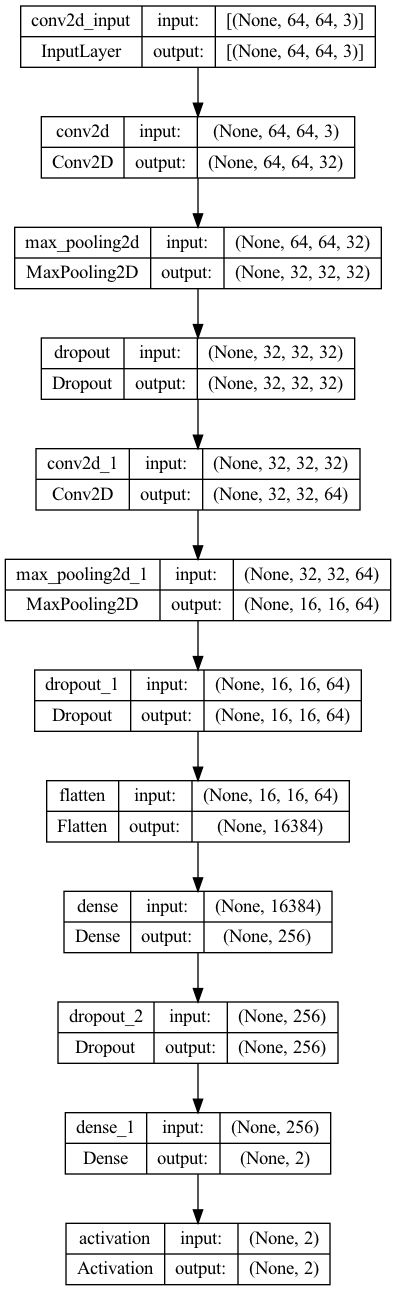

In [21]:
from keras.utils import plot_model
from IPython.display import Image
import pydot


# show the CNN model architecture with GRaphViz
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Display the plot in the Jupyter notebook
Image(filename='model_plot.png')



# Model Evaluation

## Score

In [22]:
score = model.evaluate(testX, testY, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

2023-01-09 01:08:41.315404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.27536311745643616 / Test accuracy: 0.8827499151229858


## Graphs

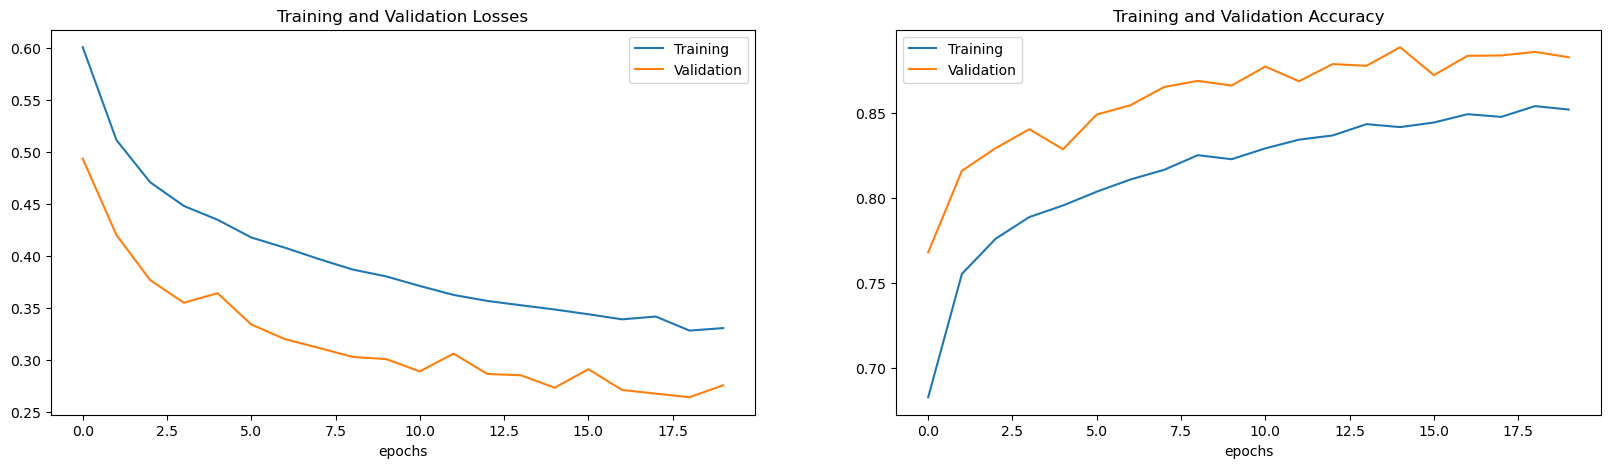

In [23]:

%matplotlib inline
# Plot the model, initialize figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

# Plot training and validation loss
axs[0].plot(H.history['loss'])
axs[0].plot(H.history['val_loss'])
axs[0].legend(['Training', 'Validation'])
axs[0].set_title('Training and Validation Losses')
axs[0].set_xlabel('epochs')

# Plot training and validation accuracy
axs[1].plot(H.history['accuracy'])
axs[1].plot(H.history['val_accuracy'])
axs[1].legend(['Training', 'Validation'])
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('epochs')

plt.show()

## Classification report


In [1]:
from sklearn.metrics import classification_report,confusion_matrix
predicitions = model.predict(testX)
predicitions = np.argmax(predicitions, axis=1)
print(classification_report(testY.argmax(axis=1), predicitions))
print(testY.shape)

NameError: name 'model' is not defined

## Confusion matrix

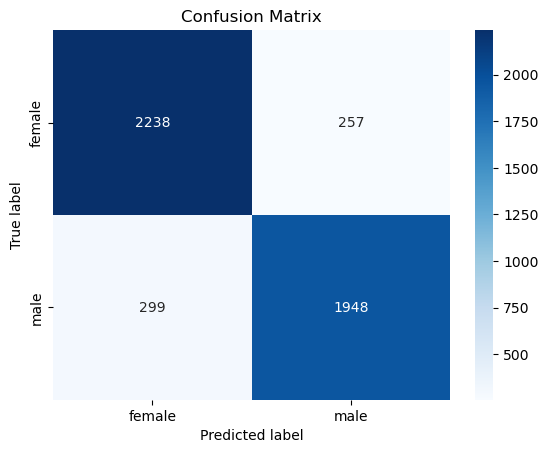

In [25]:

testY = np.argmax(testY, axis=1)
# Calculate the confusion matrix
confusion_matrix = tf.math.confusion_matrix(testY, predicitions).numpy()

# Plot the confusion matrix using seaborn
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g',xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

# Predictions on new data


In [45]:
images_to_predict = 'little_dataset'
test_images = []
for imagePath in os.listdir(images_to_predict):
    # load the image
    image = load_img(os.path.join(images_to_predict, imagePath), target_size=target_size)
    # image to array
    image = img_to_array(image)
    test_images.append(image)
    prediction = model.predict(np.array([image]))
    print(f'Image: {imagePath}')
    print(f'prediction before : {prediction}')
    print(f'prediction after : {np.argmax(prediction)}')
    if prediction[0][0] > 0:
        print('male')
    else:
        print('female')
    




1/1 [==============================] - 0s 11ms/step
Image: 049.jpg
prediction before : [[0. 1.]]
prediction after : 1
female
1/1 [==============================] - 0s 13ms/step
Image: 048.jpg
prediction before : [[0. 1.]]
prediction after : 1
female
1/1 [==============================] - 0s 11ms/step
Image: 040.jpg
prediction before : [[1. 0.]]
prediction after : 0
male
1/1 [==============================] - 0s 11ms/step
Image: 041.jpg
prediction before : [[1. 0.]]
prediction after : 0
male
1/1 [==============================] - 0s 12ms/step
Image: 043.jpg
prediction before : [[1. 0.]]
prediction after : 0
male
1/1 [==============================] - 0s 11ms/step
Image: 042.jpg
prediction before : [[1. 0.]]
prediction after : 0
male
1/1 [==============================] - 0s 12ms/step
Image: 046.jpg
prediction before : [[0. 1.]]
prediction after : 1
female
1/1 [==============================] - 0s 11ms/step
Image: 047.jpg
prediction before : [[1. 0.]]
prediction after : 0
male
1/1 [=====